# 기본세팅

In [ ]:
# 구글드라이브 연동
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# 구글 드라이브 파일 확인
!ls '/gdrive/My Drive/temp/'

# 반복되는 드라이브 경로 변수화
drive_path = '/gdrive/My Drive/temp/'

Mounted at /gdrive
 매수종목1.txt
 매수종목2.txt
 aclImdb.zip
 adult.data
 app_clf
 auto-mpg.csv
 bmi_500.csv
 citibike.csv
 CNN_routers_model.h5
 Covid19GenAgeCaseInf.csv
 Covid19InfState.csv
 Covid19NatInfState.csv
 Covid19SidoInfState.csv
 매수종목.csv
 database
 data_mine.csv
 DataNetflixRevenue2020_V2.csv
 DataNetflixSubscriber2020_V2.csv
 data_population.csv
 data_studentlist_en.csv
 diabetes.csv
 example.docx
 glove.6B.zip
 height_weight.txt
 Helloword.xlsx
 HelloWorld.xlsx
 KOBIS__.xlsx
 lenna.png
 little-char.png
 LSTM_CNN_model.h5
 LSTM_model.h5
 LSTM_routers_model.h5
 ml-latest-small
 movieclassifier
 NetflixsRevenue2018toQ2_2020.csv
 NetflixSubscribersbyCountryfrom2018toQ2_2020.csv
 netflix_titles.csv
 open
 open.zip
 population_number.csv
 ram_price.csv
 ratings_small.txt
 ratings_test.txt
 ratings_train.txt
 sample1.pdf
 sample2.pdf
 sample_merge.pdf
 sample.xlsx
 santander-customer-satisfaction
 score.csv
 simpleRNN_model.h5
 sonar.csv
 stock-data.csv
'stock price.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set(font_scale=2.5)

import missingno as msno

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import log_loss, make_scorer

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier,VotingClassifier
from lightgbm import LGBMClassifier

# Train
- 완전 중복데이터를 제거하면 loss가 커짐

In [ ]:
train = pd.read_csv(drive_path + 'open/train.csv')
test = pd.read_csv(drive_path + 'open/test.csv')

In [ ]:
df1 = train.copy()

In [ ]:
train_adj = df1

## Car, Reality 
- gender, FLAG_MOBIL,phone, work_phone,email은 크게 의미가 없는 피쳐라 판단
- car, reality값을 0과 1로 더미화 시킴

In [ ]:
train_adj['car'].replace({'N':0,'Y':1},inplace=True)
train_adj['car']

0        0
1        0
2        1
3        0
4        1
        ..
26452    0
26453    0
26454    1
26455    0
26456    0
Name: car, Length: 26457, dtype: int64

In [ ]:
train_adj['reality'].replace({'N':0,'Y':1},inplace=True)
train_adj['reality']

0        0
1        1
2        1
3        1
4        1
        ..
26452    0
26453    1
26454    0
26455    1
26456    0
Name: reality, Length: 26457, dtype: int64

## child_num, family_size
- family_size 일반화 성능up

In [ ]:
train_adj['child_num'][train_adj['child_num']>=3] = 3
train_adj['family_size'][train_adj['family_size']>=5] = 5

## occyp_type 결측치 제거
- 대통합 시켰을 때 일반화 성능이 가장 좋았음

In [ ]:
train_adj['occyp_type'][(train_adj['occyp_type'].isna()) & (train_adj['income_type'] == 'Pensioner')] = 'Retired'

In [ ]:
# 'Commercial associate': 'Laborers', 'Working':'Laborers','State servant':'Core staff'

train_adj['occyp_type'][(train_adj['occyp_type'].isna())& (train_adj['income_type']=='State servant')]= 'Core staff'
train_adj['occyp_type'][(train_adj['occyp_type'].isna())& (train_adj['income_type']=='Working')]= 'Laborers'
train_adj['occyp_type'][(train_adj['occyp_type'].isna())& (train_adj['income_type']=='Commercial associate')]= 'Sales staff'

In [ ]:

train_adj['occyp_type'][(train_adj['occyp_type']=='Cleaning staff') | (train_adj['occyp_type']=='Cooking staff') | (train_adj['occyp_type']=='Drivers') | 
                        (train_adj['occyp_type']=='Laborers') | (train_adj['occyp_type']=='Low-skill Laborers') | (train_adj['occyp_type']=='Security staff') | 
                        (train_adj['occyp_type']=='Waiters/barmen staff')]='Laborwk'
train_adj['occyp_type'][(train_adj['occyp_type']=='Accountants') | (train_adj['occyp_type']=='Core staff') | (train_adj['occyp_type']=='HR staff') | 
                        (train_adj['occyp_type']=='Medicine staff') | (train_adj['occyp_type']=='Private service staff') | 
                        (train_adj['occyp_type']=='Realty agents') | (train_adj['occyp_type']=='Sales staff') | (train_adj['occyp_type']=='Secretaries')]='officewk'
train_adj['occyp_type'][(train_adj['occyp_type']=='Managers') | (train_adj['occyp_type']=='High skill tech staff') | (train_adj['occyp_type']=='IT staff')] = 'hightecwk'
train_adj['occyp_type'][(train_adj['occyp_type'].isna())& (train_adj['income_type']=='Student')]= 'officewk'


In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(y='occyp_type',data=train_adj)

## Income_total logscale
- 값의 폭이 상당히 크기 때문에 변환을 진행
- 결과는 똑같았음

In [ ]:
train_adj['income_log'] = np.log(train_adj['income_total'])

## 나이변환
- 딱히 좋아지진 않음 특히 구간으로 바꿀시 더 성능저하가 됨

In [ ]:
# 나이 변환
train_adj['age']= (train_adj['DAYS_BIRTH']*(-1)) // (365) 
train_adj['age'].max()

In [ ]:
#나이에 따른 가중치 
score_labels={1: 69, 2: 77, 3: 84, 4: 93, 5: 104, 6: 110}
bins = [20,25,30,35,42,50,999]
train_adj['age_score'] = np.digitize(train_adj['age'],bins=bins)
train_adj['age_score'].replace(score_labels,inplace=True)
train_adj[['age','age_score']]

## 고용일, begin일
- begin은 bin으로 바꾸는게 유의미하게 효과적임
- 고용점수 성능향상에 도움됨

In [ ]:
# 고용일 변환 
train_adj['DAYS_EMPLOYED'].replace(365243,0,inplace=True)
train_adj['employ_month'] = (train_adj['DAYS_EMPLOYED']*(-1)) // (30)

score_labels={1: 20, 2: 24, 3: 29, 4: 36}
bins = [0,13,37,72,999]
train_adj['employ_score'] = np.digitize(train_adj['employ_month'],bins=bins)
train_adj['employ_score'].replace(score_labels,inplace=True)
train_adj[['DAYS_EMPLOYED','employ_month','employ_score']]

In [ ]:
# 신용카드 사용일자 월단위 변환
train_adj['begin_month'] = (train_adj['begin_month']*(-1))
train_adj['begin_month']

In [ ]:
train_adj['begin_bin'] = 0
train_adj['begin_bin'][(train_adj['begin_month']>=0)&(train_adj['begin_month']<=3)]=0
train_adj['begin_bin'][train_adj['begin_month'] >= 4]=1
train_adj['begin_bin'].value_counts()

## edu_type mapping
- 교육 수준은 양적으로 볼 수 있다고 판단하여 일단 교육수준이 높을수록 높은 값을 할당
- 'Lower secondary','Secondary / secondary special','Incomplete higher','Higher education','Academic degree' 순으로 1,2,3,4,5 매핑

In [ ]:
train_adj['edu_type']

In [ ]:
edu_dic = {'Lower secondary':1, 'Secondary / secondary special':2, 'Incomplete higher':3, 'Higher education':4, 'Academic degree':5}
train_adj['edu_type'].replace(edu_dic,inplace=True)
train_adj['edu_type']

## family_type 병합

In [ ]:
train_adj['family_type'].value_counts()

In [ ]:
sns.countplot(y= train_adj.family_type)


In [ ]:
train_adj['family_type'][train_adj['family_type']=='Single / not married'] = 'Single'
train_adj['family_type'][train_adj['family_type']=='Separated'] = 'Separated'
train_adj['family_type'][train_adj['family_type']=='Widow'] = 'Separated'
train_adj['family_type'][train_adj['family_type']=='Civil marriage'] = 'Married'
train_adj['family_type'].value_counts()

In [ ]:
train_adj['family_type'][train_adj['family_type']=='Single / not married'] = 'Single'
train_adj['family_type'][train_adj['family_type']=='Separated'] = 'Single'
train_adj['family_type'][train_adj['family_type']=='Widow'] = 'Single'
train_adj['family_type'][train_adj['family_type']=='Civil marriage'] = 'Married'
train_adj['family_type'].value_counts()

In [ ]:
sns.countplot(y= train_adj.family_type)

In [ ]:
train_adj['family_type'][train_adj['family_type']=='Single'] = 0
train_adj['family_type'][train_adj['family_type']=='Married'] = 1
train_adj['family_type'] = train_adj['family_type'].astype('int')

## house_type dummies
- house type 은 축소 시켜주는게 좋았음

In [ ]:
train_adj['house_type'].value_counts()

In [ ]:
sns.countplot(y= train_adj.house_type)

In [ ]:
train_adj['house_type'][train_adj['house_type'] == 'Municipal apartment' ] = 'Rented apartment'
train_adj['house_type'][train_adj['house_type'] == 'Office apartment' ] = 'Rented apartment'
train_adj['house_type'][train_adj['house_type'] == 'Co-op apartment' ] = 'House / apartment'
train_adj['house_type'].value_counts()


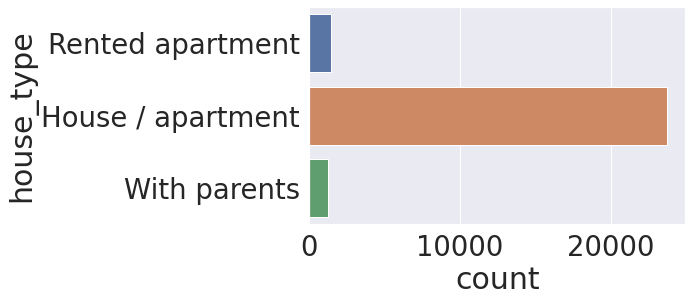

In [ ]:
sns.countplot(y= train_adj.house_type)

In [ ]:
train_adj['house_score'] = 0
train_adj['house_score'][train_adj['house_type'] == 'House / apartment' ] = 42
train_adj['house_score'][train_adj['house_type'] == 'Rented apartment' ] = 28
train_adj['house_score'][train_adj['house_type'] == 'With parents' ] = 32

# Modeling
- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- KNN
- Logistic regression
- Linear Discriminant Analysis


- 연속형 변수를 bin으로 나눈 것을 쓰는 것보다 그대로 쓰는게 logloss에 더 좋음
- LGBM성능이 가장 좋은 편
- 애매하다고 설정한 변수들 빼도 성능이 크게 달라지지 않음
- 직장 타입, 자녀수도 밸런스 맞추겠다고 줄인다고 달라지는건 없었음

## LGBM
- 마지막 변수 선택

In [ ]:
from sklearn.preprocessing import OneHotEncoder
object_col = []
for col in train_adj.columns:
    if train_adj[col].dtype == 'object':
        object_col.append(col)
object_col

['gender', 'income_type', 'house_type', 'occyp_type']

In [ ]:
from sklearn.preprocessing import OneHotEncoder
train_adj.fillna('NAN', inplace=True)
enc = OneHotEncoder()
enc.fit(train_adj.loc[:,object_col])


train_onehot_df = pd.DataFrame(enc.transform(train_adj.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train_adj.drop(object_col, axis=1, inplace=True)
train_adj = pd.concat([train_adj, train_onehot_df], axis=1)
train_adj

,index,car,reality,child_num,income_total,edu_type,family_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit,income_log,age,age_score,employ_month,employ_score,begin_bin,house_score,gender_F,gender_M,income_type_Commercial associate,income_type_Pensioner,income_type_State servant,income_type_Student,income_type_Working,house_type_House / apartment,house_type_Rented apartment,house_type_With parents,occyp_type_Laborwk,occyp_type_Retired,occyp_type_hightecwk,occyp_type_officewk
0,0,0,0,0,202500.0,4,1,-13899,-4709,1,0,0,0,2.0,6.0,1.0,12.218495,38,93,156,36,1,28,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,0,1,1,247500.0,2,1,-11380,-1540,1,0,0,1,3.0,5.0,1.0,12.419166,31,84,51,29,1,42,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,1,1,0,450000.0,4,1,-19087,-4434,1,0,1,0,2.0,22.0,2.0,13.017003,52,110,147,36,1,42,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,0,1,0,202500.0,2,1,-15088,-2092,1,0,1,0,2.0,37.0,0.0,12.218495,41,93,69,29,1,42,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,1,1,0,157500.0,4,1,-15037,-2105,1,0,0,0,2.0,26.0,2.0,11.967181,41,93,70,29,1,42,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,0,0,2,225000.0,2,1,-12079,-1984,1,0,0,0,4.0,2.0,1.0,12.323856,33,84,66,29,0,42,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
26453,26453,0,1,1,180000.0,4,0,-15291,-2475,1,0,0,0,2.0,47.0,2.0,12.100712,41,93,82,36,1,42,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
26454,26454,1,0,0,292500.0,2,1,-10082,-2015,1,0,0,0,2.0,25.0,2.0,12.586220,27,77,67,29,1,32,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
26455,26455,0,1,0,171000.0,3,0,-10145,-107,1,0,0,0,1.0,59.0,2.0,12.049419,27,77,3,20,1,42,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
train_adj.columns

Index(['index', 'car', 'reality', 'child_num', 'income_total', 'edu_type',
       'family_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL',
       'work_phone', 'phone', 'email', 'family_size', 'begin_month', 'credit',
       'income_log', 'age', 'age_score', 'employ_month', 'employ_score',
       'begin_bin', 'house_score', 'gender_F', 'gender_M',
       'income_type_Commercial associate', 'income_type_Pensioner',
       'income_type_State servant', 'income_type_Student',
       'income_type_Working', 'house_type_House / apartment',
       'house_type_Rented apartment', 'house_type_With parents',
       'occyp_type_Laborwk', 'occyp_type_Retired', 'occyp_type_hightecwk',
       'occyp_type_officewk'],
      dtype='object')

In [ ]:
X = train_adj.loc[:,['reality','phone','family_size',  
       'DAYS_BIRTH','DAYS_EMPLOYED','age_score','employ_score',
       'begin_bin','edu_type', 'family_type','income_total',
       'income_type_Commercial associate',
       'income_type_Pensioner', 'income_type_State servant',
       'income_type_Student', 'income_type_Working',
       'house_type_House / apartment',
       'house_type_Rented apartment', 'house_type_With parents',
       'occyp_type_Laborwk', 'occyp_type_Retired',
       'occyp_type_hightecwk', 'occyp_type_officewk']]
y = train_adj['credit']

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train_adj, train_adj['credit']):
    folds.append((train_idx, valid_idx))
len(folds[0][0]),len(folds[0][1]),len(folds[1][0]),len(folds[1][1])

(21165, 5292, 21165, 5292)

In [ ]:
# 'reg_alpha': 1.7560829253683595e-07, 'reg_lambda': 0.07339153040632079, 'max_depth': 15, 'num_leaves': 187, 'colsample_bytree': 0.8627622080115674, 'subsample': 0.35183125621386324, 'subsample_freq': 4, 'min_child_samples': 16, 'max_bin': 459
import random
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx].values, X.iloc[valid_idx].values, y[train_idx].values, y[valid_idx].values 
    lgb = LGBMClassifier(n_estimators=1000,reg_alpha = 1.756, reg_lambda = 0.073,
                         num_leaves = 187, colsample_bytree = 0.862, subsample = 0.3518,
                         subsample_freq = 4, min_child_samples = 16, max_depth=15,
                         max_bin= 459)
    lgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=30,
            verbose=100)
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

====================================1============================================
Training until validation scores don't improve for 30 rounds.
[100]	training's multi_logloss: 0.584954	valid_1's multi_logloss: 0.72743
[200]	training's multi_logloss: 0.513731	valid_1's multi_logloss: 0.715715
Early stopping, best iteration is:
[216]	training's multi_logloss: 0.505322	valid_1's multi_logloss: 0.713882


====================================2============================================
Training until validation scores don't improve for 30 rounds.
[100]	training's multi_logloss: 0.583661	valid_1's multi_logloss: 0.733517
Early stopping, best iteration is:
[150]	training's multi_logloss: 0.538532	valid_1's multi_logloss: 0.729857


====================================3============================================
Training until validation scores don't improve for 30 rounds.
[100]	training's multi_logloss: 0.583154	valid_1's multi_logloss: 0.732041
[200]	training's multi_logloss: 0.510346	vali

In [ ]:
list(X.columns)

['reality',
 'phone',
 'family_size',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'age_score',
 'employ_score',
 'begin_bin',
 'edu_type',
 'family_type',
 'income_total',
 'income_type_Commercial associate',
 'income_type_Pensioner',
 'income_type_State servant',
 'income_type_Student',
 'income_type_Working',
 'house_type_House / apartment',
 'house_type_Rented apartment',
 'house_type_With parents',
 'occyp_type_Laborwk',
 'occyp_type_Retired',
 'occyp_type_hightecwk',
 'occyp_type_officewk']

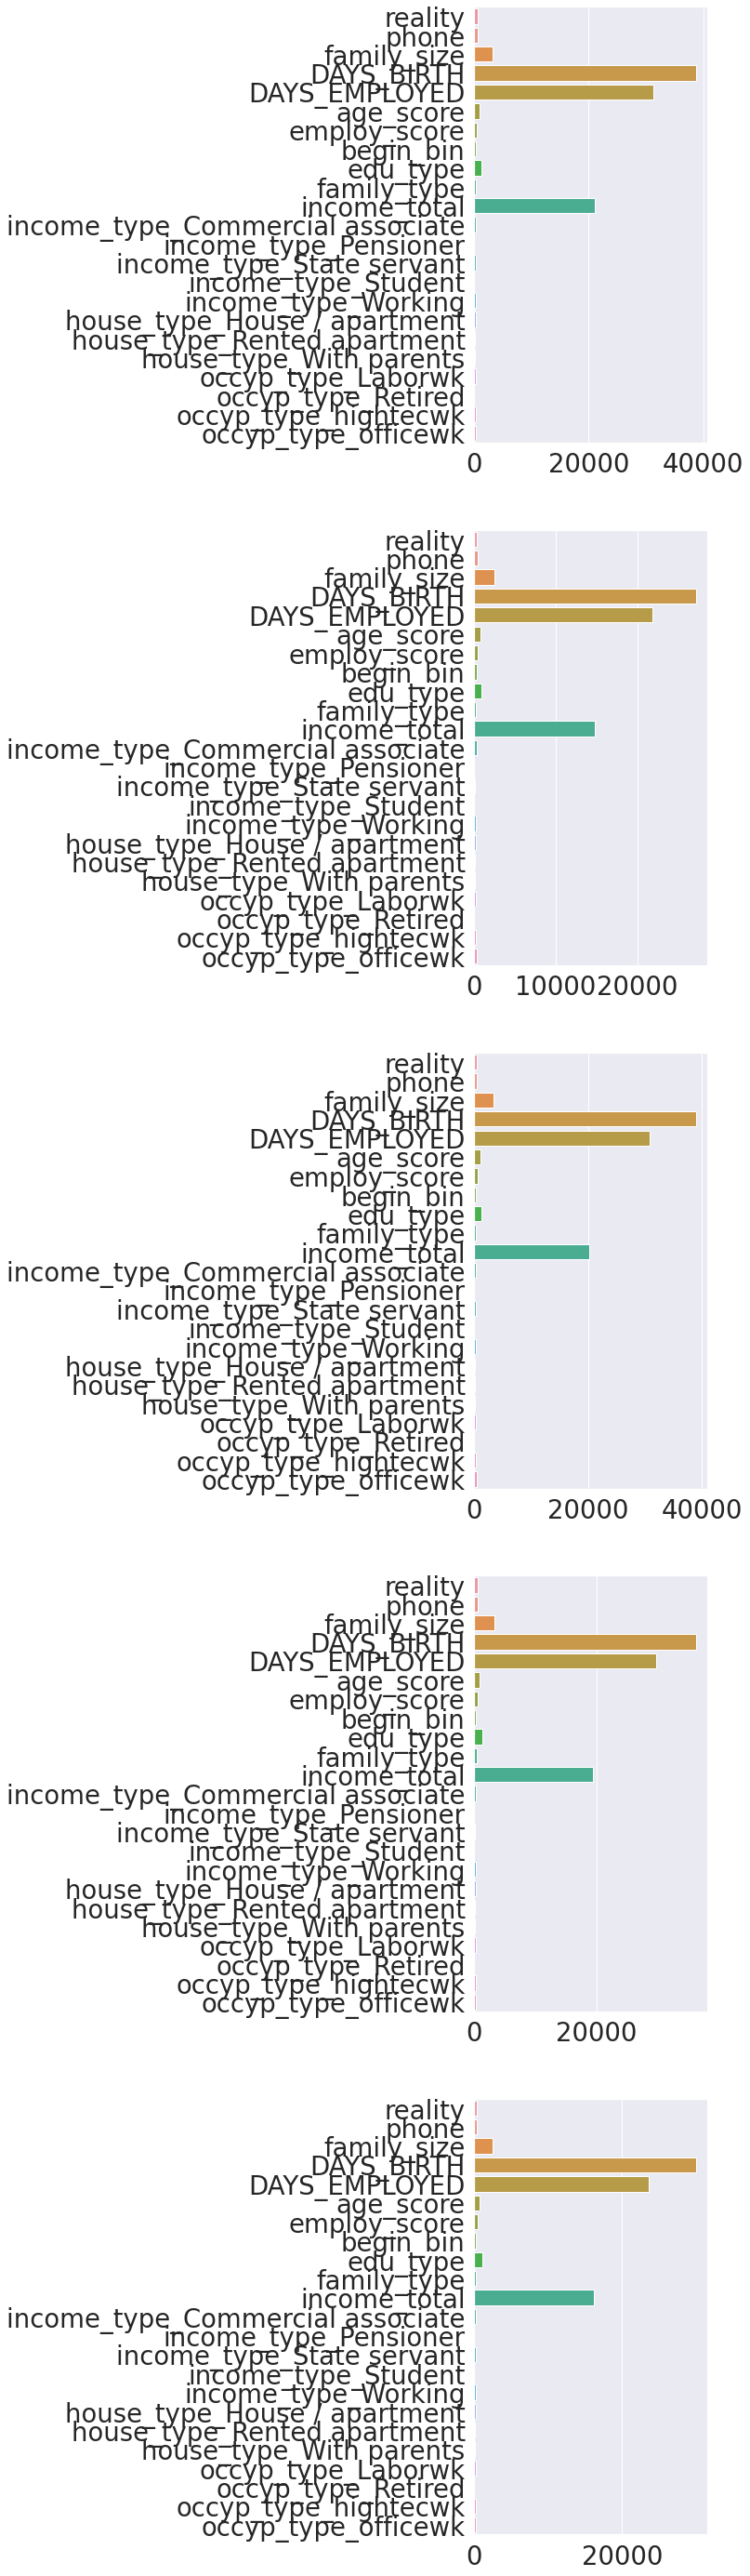

In [ ]:
fig, ax = plt.subplots(5,1,figsize= (4,50))
for i in range(5):
  sns.barplot(x = lgb_models[i].feature_importances_,y = list(X.columns),ax=ax[i])

# Tuning

In [ ]:
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split

X = train_adj.loc[:,['reality','phone','family_size',  
       'DAYS_BIRTH','DAYS_EMPLOYED','age_score','employ_score','house_score'
       'begin_bin','edu_type', 'family_type','income_total',
       'income_type_Commercial associate',
       'income_type_Pensioner', 'income_type_State servant',
       'income_type_Student', 'income_type_Working',
       'house_type_House / apartment',
       'house_type_Rented apartment', 'house_type_With parents',
       'occyp_type_Laborwk', 'occyp_type_Retired',
       'occyp_type_hightecwk', 'occyp_type_officewk']]
y = train_adj['credit']

KeyError: ignored

In [ ]:
def objective(trial,X=X,y=y):
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)

    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }

    model = LGBMClassifier(**params_lgb)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=100,
        verbose=False,
    )
    lgb_pred = model.predict_proba(X_valid)
    log_score = log_loss(y_valid, lgb_pred)
    return log_score

In [ ]:
import optuna
from sklearn.metrics import log_loss
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-05-24 02:25:22,395] A new study created in memory with name: lgbm_parameter_opt
[I 2021-05-24 02:25:41,119] Trial 0 finished with value: 0.7220469008903753 and parameters: {'reg_alpha': 1.12424581642324e-05, 'reg_lambda': 0.08556428806974939, 'max_depth': 15, 'num_leaves': 154, 'colsample_bytree': 0.4936111842654619, 'subsample': 0.40919616423534183, 'subsample_freq': 1, 'min_child_samples': 88, 'max_bin': 380}. Best is trial 0 with value: 0.7220469008903753.
[I 2021-05-24 02:25:48,604] Trial 1 finished with value: 0.7207981008315025 and parameters: {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}. Best is trial 1 with value: 0.7207981008315025.
[I 2021-05-24 02:26:07,577] Trial 2 finished with value: 0.7225272839554265 and parameters: {'reg_alpha': 1.2964031109077052e-05, 'reg_lambd

Best Score: 0.7167068794425429
Best trial: {'reg_alpha': 9.145366937509386e-06, 'reg_lambda': 0.008790499283853408, 'max_depth': 14, 'num_leaves': 114, 'colsample_bytree': 0.47322294090686734, 'subsample': 0.6466238370778892, 'subsample_freq': 1, 'min_child_samples': 92, 'max_bin': 277}


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# 각 파라미터들의 상관관계
optuna.visualization.plot_contour(
    study,
    params=[
        "max_depth",
        "num_leaves",
        "colsample_bytree",
        "subsample",
        "subsample_freq",
        "min_child_samples",
        "max_bin",
    ],
)

In [ ]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

# TEST

In [ ]:
test = pd.read_csv(drive_path + 'open/test.csv')
submit = pd.read_csv(drive_path + 'open/sample_submission.csv')

In [ ]:
df1 = test.copy()

In [ ]:
train_adj = df1
train_adj

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,Accountants,2.0,-19.0
9996,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,Laborers,2.0,-34.0
9997,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,Medicine staff,2.0,-55.0
9998,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,NaN,2.0,-33.0


## Car, Reality 
- gender, FLAG_MOBIL,phone, work_phone,email은 크게 의미가 없는 피쳐라 판단
- car, reality값을 0과 1로 더미화 시킴

In [ ]:
train_adj['car'].replace({'N':0,'Y':1},inplace=True)
train_adj['car']

0       1
1       0
2       0
3       1
4       1
       ..
9995    1
9996    1
9997    0
9998    1
9999    0
Name: car, Length: 10000, dtype: int64

In [ ]:
train_adj['reality'].replace({'N':0,'Y':1},inplace=True)
train_adj['reality']

0       0
1       1
2       1
3       0
4       1
       ..
9995    1
9996    1
9997    1
9998    0
9999    1
Name: reality, Length: 10000, dtype: int64

## child_num, family_size
- family_size 일반화 성능up

In [ ]:
train_adj['child_num'][train_adj['child_num']>=3] = 3
train_adj['family_size'][train_adj['family_size']>=5] = 5

## occyp_type 결측치 제거
- 대통합 시켰을 때 일반화 성능이 가장 좋았음

In [ ]:
train_adj['occyp_type'][(train_adj['occyp_type'].isna()) & (train_adj['income_type'] == 'Pensioner')] = 'Retired'

In [ ]:
# 'Commercial associate': 'Laborers', 'Working':'Laborers','State servant':'Core staff'

train_adj['occyp_type'][(train_adj['occyp_type'].isna())& (train_adj['income_type']=='State servant')]= 'Core staff'
train_adj['occyp_type'][(train_adj['occyp_type'].isna())& (train_adj['income_type']=='Working')]= 'Laborers'
train_adj['occyp_type'][(train_adj['occyp_type'].isna())& (train_adj['income_type']=='Commercial associate')]= 'Sales staff'

In [ ]:

train_adj['occyp_type'][(train_adj['occyp_type']=='Cleaning staff') | (train_adj['occyp_type']=='Cooking staff') | (train_adj['occyp_type']=='Drivers') | 
                        (train_adj['occyp_type']=='Laborers') | (train_adj['occyp_type']=='Low-skill Laborers') | (train_adj['occyp_type']=='Security staff') | 
                        (train_adj['occyp_type']=='Waiters/barmen staff')]='Laborwk'
train_adj['occyp_type'][(train_adj['occyp_type']=='Accountants') | (train_adj['occyp_type']=='Core staff') | (train_adj['occyp_type']=='HR staff') | 
                        (train_adj['occyp_type']=='Medicine staff') | (train_adj['occyp_type']=='Private service staff') | 
                        (train_adj['occyp_type']=='Realty agents') | (train_adj['occyp_type']=='Sales staff') | (train_adj['occyp_type']=='Secretaries')]='officewk'
train_adj['occyp_type'][(train_adj['occyp_type']=='Managers') | (train_adj['occyp_type']=='High skill tech staff') | (train_adj['occyp_type']=='IT staff')] = 'hightecwk'
train_adj['occyp_type'].value_counts()

Laborwk      3759
officewk     3335
Retired      1699
hightecwk    1207
Name: occyp_type, dtype: int64

## Income_total logscale
- 값의 폭이 상당히 크기 때문에 변환을 진행
- 결과는 똑같았음

In [ ]:
train_adj['income_log'] = np.log(train_adj['income_total'])

## 나이변환
- 딱히 좋아지진 않음 특히 구간으로 바꿀시 더 성능저하가 됨

In [ ]:
# 나이 변환
train_adj['age']= (train_adj['DAYS_BIRTH']*(-1)) // (365) 
train_adj['age'].max()

68

In [ ]:
#나이에 따른 가중치 
score_labels={1: 69, 2: 77, 3: 84, 4: 93, 5: 104, 6: 110}
bins = [20,25,30,35,42,50,999]
train_adj['age_score'] = np.digitize(train_adj['age'],bins=bins)
train_adj['age_score'].replace(score_labels,inplace=True)
train_adj[['age','age_score']]

,age,age_score
0,60,110
1,51,110
2,43,104
3,52,110
4,48,104
...,...,...
9995,50,110
9996,29,77
9997,57,110
9998,45,104


## 고용일, begin일
- begin은 bin으로 바꾸는게 유의미하게 효과적임
- 고용점수 성능향상에 도움됨

In [ ]:
# 고용일 변환 
train_adj['DAYS_EMPLOYED'].replace(365243,0,inplace=True)
train_adj['employ_month'] = (train_adj['DAYS_EMPLOYED']*(-1)) // (30)

score_labels={1: 20, 2: 24, 3: 29, 4: 36}
bins = [0,13,37,72,999]
train_adj['employ_score'] = np.digitize(train_adj['employ_month'],bins=bins)
train_adj['employ_score'].replace(score_labels,inplace=True)
train_adj[['DAYS_EMPLOYED','employ_month','employ_score']]

,DAYS_EMPLOYED,employ_month,employ_score
0,0,0,20
1,-8671,289,36
2,-217,7,20
3,-2531,84,36
4,-9385,312,36
...,...,...,...
9995,-5434,181,36
9996,-1315,43,29
9997,-14018,467,36
9998,-1085,36,24


In [ ]:
# 신용카드 사용일자 월단위 변환
train_adj['begin_month'] = (train_adj['begin_month']*(-1))
train_adj['begin_month']

0       60.0
1       36.0
2       40.0
3       41.0
4        8.0
        ... 
9995    19.0
9996    34.0
9997    55.0
9998    33.0
9999    11.0
Name: begin_month, Length: 10000, dtype: float64

In [ ]:
train_adj['begin_bin'] = 0
train_adj['begin_bin'][(train_adj['begin_month']>=0)&(train_adj['begin_month']<=3)]=0
train_adj['begin_bin'][train_adj['begin_month'] >= 4]=1
train_adj['begin_bin'].value_counts()

1    9408
0     592
Name: begin_bin, dtype: int64

## edu_type mapping
- 교육 수준은 양적으로 볼 수 있다고 판단하여 일단 교육수준이 높을수록 높은 값을 할당
- 'Lower secondary','Secondary / secondary special','Incomplete higher','Higher education','Academic degree' 순으로 1,2,3,4,5 매핑

In [ ]:
train_adj['edu_type']

0       Secondary / secondary special
1                    Higher education
2       Secondary / secondary special
3       Secondary / secondary special
4                    Higher education
                    ...              
9995                Incomplete higher
9996    Secondary / secondary special
9997    Secondary / secondary special
9998    Secondary / secondary special
9999                 Higher education
Name: edu_type, Length: 10000, dtype: object

In [ ]:
edu_dic = {'Lower secondary':1, 'Secondary / secondary special':2, 'Incomplete higher':3, 'Higher education':4, 'Academic degree':5}
train_adj['edu_type'].replace(edu_dic,inplace=True)
train_adj['edu_type']

0       2
1       4
2       2
3       2
4       4
       ..
9995    3
9996    2
9997    2
9998    2
9999    4
Name: edu_type, Length: 10000, dtype: int64

## family_type 병합

In [ ]:
train_adj['family_type'].value_counts()

Married                 6852
Single / not married    1333
Civil marriage           822
Separated                564
Widow                    429
Name: family_type, dtype: int64

In [ ]:
train_adj['family_type'][train_adj['family_type']=='Single / not married'] = 'Single'
train_adj['family_type'][train_adj['family_type']=='Separated'] = 'Separated'
train_adj['family_type'][train_adj['family_type']=='Widow'] = 'Separated'
train_adj['family_type'][train_adj['family_type']=='Civil marriage'] = 'Married'
train_adj['family_type'].value_counts()

Married      7674
Single       1333
Separated     993
Name: family_type, dtype: int64

In [ ]:
train_adj['family_type'][train_adj['family_type']=='Single / not married'] = 'Single'
train_adj['family_type'][train_adj['family_type']=='Separated'] = 'Single'
train_adj['family_type'][train_adj['family_type']=='Widow'] = 'Single'
train_adj['family_type'][train_adj['family_type']=='Civil marriage'] = 'Married'
train_adj['family_type'].value_counts()

Married    7674
Single     2326
Name: family_type, dtype: int64

In [ ]:
train_adj['family_type'][train_adj['family_type']=='Single'] = 0
train_adj['family_type'][train_adj['family_type']=='Married'] = 1
train_adj['family_type'] = train_adj['family_type'].astype('int')

## house_type dummies
- house type 은 축소 시켜주는게 좋았음

In [ ]:
train_adj['house_type'].value_counts()

House / apartment      8895
With parents            519
Municipal apartment     310
Rented apartment        146
Office apartment         72
Co-op apartment          58
Name: house_type, dtype: int64

In [ ]:
train_adj['house_type'][train_adj['house_type'] == 'Municipal apartment' ] = 'Rented apartment'
train_adj['house_type'][train_adj['house_type'] == 'Office apartment' ] = 'Rented apartment'
train_adj['house_type'][train_adj['house_type'] == 'Co-op apartment' ] = 'House / apartment'
train_adj['house_type'].value_counts()


House / apartment    8953
Rented apartment      528
With parents          519
Name: house_type, dtype: int64

In [ ]:
train_adj['house_score'] = 0
train_adj['house_score'][train_adj['house_type'] == 'House / apartment' ] = 42
train_adj['house_score'][train_adj['house_type'] == 'Rented apartment' ] = 28
train_adj['house_score'][train_adj['house_type'] == 'With parents' ] = 32

#Fit Transpose

In [ ]:
from sklearn.preprocessing import OneHotEncoder
object_col = []
for col in train_adj.columns:
    if train_adj[col].dtype == 'object':
        object_col.append(col)
object_col

['gender', 'income_type', 'house_type', 'occyp_type']

In [ ]:
from sklearn.preprocessing import OneHotEncoder
train_adj.fillna('NAN', inplace=True)
enc = OneHotEncoder()
enc.fit(train_adj.loc[:,object_col])


train_onehot_df = pd.DataFrame(enc.transform(train_adj.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train_adj.drop(object_col, axis=1, inplace=True)
train_adj = pd.concat([train_adj, train_onehot_df], axis=1)
train_adj

,index,car,reality,child_num,income_total,edu_type,family_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,income_log,age,age_score,employ_month,employ_score,begin_bin,house_score,gender_F,gender_M,income_type_Commercial associate,income_type_Pensioner,income_type_State servant,income_type_Student,income_type_Working,house_type_House / apartment,house_type_Rented apartment,house_type_With parents,occyp_type_Laborwk,occyp_type_Retired,occyp_type_hightecwk,occyp_type_officewk
0,26457,1,0,0,112500.0,2,1,-21990,0,1,0,1,0,2.0,60.0,11.630709,60,110,0,20,1,42,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,26458,0,1,0,135000.0,4,1,-18964,-8671,1,0,1,0,2.0,36.0,11.813030,51,110,289,36,1,42,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,26459,0,1,0,69372.0,2,1,-15887,-217,1,1,1,0,2.0,40.0,11.147239,43,104,7,20,1,42,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,26460,1,0,0,112500.0,2,1,-19270,-2531,1,1,0,0,2.0,41.0,11.630709,52,110,84,36,1,42,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,26461,1,1,0,225000.0,4,1,-17822,-9385,1,1,0,0,2.0,8.0,12.323856,48,104,312,36,1,42,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,1,1,0,202500.0,3,1,-18593,-5434,1,1,1,0,2.0,19.0,12.218495,50,110,181,36,1,42,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9996,36453,1,1,0,202500.0,2,1,-10886,-1315,1,1,0,0,2.0,34.0,12.218495,29,77,43,29,1,42,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
9997,36454,0,1,0,292500.0,2,1,-21016,-14018,1,0,0,0,2.0,55.0,12.586220,57,110,467,36,1,42,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9998,36455,1,0,0,180000.0,2,1,-16541,-1085,1,0,1,0,2.0,33.0,12.100712,45,104,36,24,1,42,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
train_adj.columns

Index(['index', 'car', 'reality', 'child_num', 'income_total', 'edu_type',
       'family_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL',
       'work_phone', 'phone', 'email', 'family_size', 'begin_month',
       'income_log', 'age', 'age_score', 'employ_month', 'employ_score',
       'begin_bin', 'house_score', 'gender_F', 'gender_M',
       'income_type_Commercial associate', 'income_type_Pensioner',
       'income_type_State servant', 'income_type_Student',
       'income_type_Working', 'house_type_House / apartment',
       'house_type_Rented apartment', 'house_type_With parents',
       'occyp_type_Laborwk', 'occyp_type_Retired', 'occyp_type_hightecwk',
       'occyp_type_officewk'],
      dtype='object')

In [ ]:
X_test = train_adj.loc[:,['reality','phone','family_size',  
       'DAYS_BIRTH','DAYS_EMPLOYED','age_score','employ_score',
       'begin_bin','edu_type', 'family_type','income_total',
       'income_type_Commercial associate',
       'income_type_Pensioner', 'income_type_State servant',
       'income_type_Student', 'income_type_Working',
       'house_type_House / apartment',
       'house_type_Rented apartment', 'house_type_With parents',
       'occyp_type_Laborwk', 'occyp_type_Retired',
       'occyp_type_hightecwk', 'occyp_type_officewk']]

In [ ]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(X_test)/5

In [ ]:
submit.to_csv('20210524_test_submit_ensemble.csv', index=False) # 0.72151

In [ ]:
submit.describe()

,index,0,1,2
count,10000.00000,10000.000000,10000.000000,10000.000000
mean,31456.50000,0.119458,0.231241,0.649300
std,2886.89568,0.121369,0.200526,0.232969
min,26457.00000,0.002534,0.001826,0.000032
25%,28956.75000,0.048548,0.105997,0.562609
50%,31456.50000,0.080658,0.164843,0.715481
75%,33956.25000,0.140445,0.271089,0.810357
max,36456.00000,0.934481,0.989459,0.992688
